## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [2]:
# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare times.
    """
    import matplotlib.dates as mdates
    import os
    
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)
    
    print(f"Buscando datos entre: {flare_start_time} y {flare_end_time}")

    # Convert date columns to datetime if they aren't already
    df_combined['date'] = pd.to_datetime(df_combined['date'])
    df_fai_selected['date'] = pd.to_datetime(df_fai_selected['date'])
    df_flare_data['StartTime'] = pd.to_datetime(df_flare_data['StartTime'])
    df_flare_data['PeakTime'] = pd.to_datetime(df_flare_data['PeakTime'])
    df_flare_data['EndTime'] = pd.to_datetime(df_flare_data['EndTime'])

    # DEBUG: Verificar rangos de fechas en los dataframes
    print(f"Rango df_combined: {df_combined['date'].min()} a {df_combined['date'].max()}")
    print(f"Rango df_fai_selected: {df_fai_selected['date'].min()} a {df_fai_selected['date'].max()}")
    print(f"Rango df_flare_data PeakTime: {df_flare_data['PeakTime'].min()} a {df_flare_data['PeakTime'].max()}")

    # Filter data based on date column - método más robusto
    mask_combined = (df_combined['date'] >= flare_start_time) & (df_combined['date'] <= flare_end_time)
    df_plot = df_combined.loc[mask_combined].copy()
    
    mask_fai = (df_fai_selected['date'] >= flare_start_time) & (df_fai_selected['date'] <= flare_end_time)
    df_fai_interval = df_fai_selected.loc[mask_fai].copy()

    # DEBUG: Verificar cuántos datos encontramos
    print(f"Datos en df_plot: {len(df_plot)}")
    print(f"Datos en df_fai_interval: {len(df_fai_interval)}")

    # Si no hay datos en el rango, mostrar advertencia
    if len(df_plot) == 0:
        print(f"¡ADVERTENCIA! No hay datos en df_combined para el rango {flare_start_time} a {flare_end_time}")
        return

    plt.rcParams.update({
        "axes.titlesize": 16, "axes.labelsize": 16, 
        "xtick.labelsize": 15, "ytick.labelsize": 15, 
        "legend.fontsize": 13
    })

    # Create figure
    fig, ax = plt.subplots(figsize=(13, 5))

    # Plot XRS A and B usando el índice numérico para evitar problemas con fechas
    x_vals = range(len(df_plot))  # Usar índice numérico para el plotting
    ax.plot(x_vals, df_plot['xrsa'], label='XRS A', color='blue', linewidth=1)
    ax.plot(x_vals, df_plot['xrsb'], label='XRS B', color='red', linewidth=1)

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title(f'XRS A and B with FAI and Flare Times\n{flare_start_time:%Y-%m-%d %H:%M} to {flare_end_time:%H:%M}')
    ax.grid(True, alpha=0.3)

    # Configurar el eje X con etiquetas de tiempo reales
    n_ticks = min(10, len(df_plot))  # Máximo 10 ticks
    tick_indices = np.linspace(0, len(df_plot)-1, n_ticks, dtype=int)
    tick_times = df_plot['date'].iloc[tick_indices]
    tick_labels = [t.strftime('%H:%M') for t in tick_times]
    
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_labels)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval['date']:
        # Encontrar la posición en el plot para este tiempo FAI
        time_diff = np.abs(df_plot['date'] - fai_time)
        if len(time_diff) > 0:
            idx = time_diff.argmin()
            ax.axvline(x=idx, color='red', linestyle='-', linewidth=1.5, alpha=0.7,
                      label='FAI Alert' if fai_time == df_fai_interval['date'].iloc[0] else "")

    # Encontrar fulguraciones en el intervalo de tiempo
    flares_in_interval = df_flare_data[
        (df_flare_data['PeakTime'] >= flare_start_time) & 
        (df_flare_data['PeakTime'] <= flare_end_time)
    ]
    
    print(f"Fulguraciones encontradas en el intervalo: {len(flares_in_interval)}")

    # Colores y estilos para los diferentes tiempos de las fulguraciones
    for idx, (_, row) in enumerate(flares_in_interval.iterrows()):
        start_time = row['StartTime']
        peak_time = row['PeakTime']
        end_time = row['EndTime']
        flare_class = row.get('Class', '')
        
        # Función para encontrar la posición en el plot
        def find_time_position(time_val):
            time_diff = np.abs(df_plot['date'] - time_val)
            if len(time_diff) > 0:
                return time_diff.argmin()
            return None
        
        # Línea verde punteada para StartTime
        if flare_start_time <= start_time <= flare_end_time:
            start_pos = find_time_position(start_time)
            if start_pos is not None:
                ax.axvline(x=start_pos, color='green', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Start' if idx == 0 else "")
        
        # Línea azul discontinua para PeakTime
        
        if flare_start_time <= peak_time <= flare_end_time:
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                #ax.axvline(x=peak_pos, color='blue', linestyle='--', linewidth=2, alpha=0.8,
                ax.axvline(x=peak_pos, color='blue', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Peak' if idx == 0 else "")
                
                # AÑADIR FLECHA QUE SEÑALA EL PEAK
                # Encontrar el valor de flujo en el peak time
                peak_flux = None
                peak_time_diff = np.abs(df_plot['date'] - peak_time)
                if len(peak_time_diff) > 0:
                    peak_idx = peak_time_diff.argmin()
                    # Usar el mayor flujo entre XRS A y XRS B
                    peak_flux = max(df_plot['xrsa'].iloc[peak_idx], df_plot['xrsb'].iloc[peak_idx])
                

        
        # Línea amarilla punteada para EndTime
        if flare_start_time <= end_time <= flare_end_time:
            end_pos = find_time_position(end_time)
            if end_pos is not None:
                ax.axvline(x=end_pos, color='orange', linestyle='--', linewidth=3, alpha=0.8,
                          label='Flare End' if idx == 0 else "")
        
        # Anotación con la clase de la fulguración Y FLECHA
        if flare_class and (flare_start_time <= peak_time <= flare_end_time):
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                ax.annotate(flare_class,
                            xy=(peak_pos, ymin * 5),  # Punto destino
                            xytext=(peak_pos + 1, ymin * 15),  # Punto origen (más a la derecha y arriba)
                            fontsize=9,
                            color='darkblue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="darkblue", lw=1, alpha=0.8),
                            arrowprops=dict(arrowstyle='->',  # Flecha
                                          color='darkblue',
                                          lw=1,
                                          alpha=0.7,
                                          shrinkA=5,  # Espacio en el origen
                                          shrinkB=0))  # Sin espacio en el destino

    # Final layout with proper legend handling
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    
    fig.tight_layout()

    # Create graphics directory if it doesn't exist
    graphics_dir = "graphics"
    os.makedirs(graphics_dir, exist_ok=True)
    
    output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


#gráfica ce flux vs EM y T
def plot_xrs_vs_te_simple(days, 
                         df_full_valid, 
                         df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by=None,
                         palette="viridis",  
                         class_to_color=None):
    """
    Versión simplificada que asume que podemos hacer merge por tiempo
    """
    
    # Convertir a datetime
    df_full_valid['date'] = pd.to_datetime(df_full_valid['date'])
    df_flares_valid[time_column] = pd.to_datetime(df_flares_valid[time_column])
    
    # Hacer merge de los dataframes
    df_merged = pd.merge(df_flares_valid, df_full_valid, 
                        left_on=time_column, 
                        right_on='date', 
                        how='inner')
    
    if len(df_merged) == 0:
        print("No hay coincidencias entre los dataframes.")
        return
    
    # Filtrar datos válidos
    valid_data = df_merged.dropna(subset=[XRS, T, EM])
    
    if len(valid_data) == 0:
        print("No hay datos válidos después de filtrar NaNs.")
        return
    
    print(f"Datos válidos para graficar: {len(valid_data)}")
    
    # Preparar datos
    xrs_vals = valid_data[XRS].values
    em_vals = valid_data[EM].values
    t_vals = valid_data[T].values
    
    # Preparar labels para colores
    if color_by == "Class":
        flare_labels = valid_data["Class"].astype(str).str[0].tolist()  # solo letra B,C,M,X
    elif color_by == "Date":
        flare_labels = valid_data[time_column].dt.date.astype(str).tolist()
    elif color_by == "observatory":
        flare_labels = valid_data["observatory"].fillna("Unknown").tolist()
    else:
        flare_labels = [""] * len(valid_data)

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Configuración de plot
    plt.rcParams.update({
        "axes.titlesize": 17, "axes.labelsize": 15,
        "xtick.labelsize": 16, "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure\n{days} days ({time_column})", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    
    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature\n{days} days ({time_column})", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)

    # Leyenda
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                             label=str(lab), markersize=12) for lab in labels]
        
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left
        
        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        fig.legend(handles=handles, title=color_by,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=min(4, len(labels)), frameon=False,
                  title_fontsize=17) #tamaño de título

    # Guardar
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##

## Carpeta para gráficas

In [3]:
n=185
# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-11-04"
#window_minutes=30

fai_column="FAIalerts_WPeak" # "FAIalerts_W",  Columna en df_anticipation_time que indica si el flare tiene FAI
                        # "FAIalerts_WStart"
                        # "FAIalerts_WPeak"
                        # "FAIalerts_StartPeak"
                        # "FAIalerts_PeakEnd"
                        # "FAIalerts_startEnd"
window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered"
# all = todos los FAI segun críterios de EM y T
# true = todos los FAI segun críterios de EM, T y duración del FAI activado
# filtered = todos los FAI segun críterios de EM, T, duración del FAI activado
#            y que no están entre el peak y end de una fulguración
#method = "all"  # "all", "true" o "filtered"

output_dir = f"{fecha_actual}_Analysis_for_{n}_days/GraphicsFAI(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{duration}_{FAI_duration}"

folder = f"Graphics_{method}"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(output_dir, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")


⚠️ La carpeta de análisis ya existía: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered


In [ ]:
# Path of df_full
csv_path_full = f"{fecha_actual}_Analysis_for_{n}_days/df_full_goes_{n}.csv"
# Path of valid goes data in csv
csv_path_full_valid = f"{fecha_actual}_Analysis_for_{n}_days/df_full_{n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{fecha_actual}_Analysis_for_{n}_days/df_flares_{n}_valid.csv"

# Path of fai_selected
csv_path_fai_selected = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

# Path of anticipation_time
csv_path_anticipation_time = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

# Path of df_fai_assoc
# Path of df_fai_assoc2 -> 
csv_path_fai_assoc = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_assoc2_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_full = pd.read_csv(csv_path_full)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)

## Info dfs

In [5]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

In [6]:
df_full_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64604 entries, 0 to 64603
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       64604 non-null  object        
 1   date          64604 non-null  datetime64[ns]
 2   observatory   64604 non-null  object        
 3   xrsa          64604 non-null  float64       
 4   xrsb          64604 non-null  float64       
 5   xrsa_corr     64604 non-null  float64       
 6   xrsb_corr     64604 non-null  float64       
 7   T_cor         64604 non-null  float64       
 8   EM_cor        64604 non-null  float64       
 9   T_phot        64604 non-null  float64       
 10  EM_phot       64604 non-null  float64       
 11  EM_cor_norm   64604 non-null  float64       
 12  EM_phot_norm  64604 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 6.4+ MB


In [7]:
df_flares_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Flare_ID     2020 non-null   object        
 1   StartTime    2020 non-null   datetime64[ns]
 2   PeakTime     2020 non-null   datetime64[ns]
 3   EndTime      2020 non-null   datetime64[ns]
 4   Class        2020 non-null   object        
 5   ClassLetter  2020 non-null   object        
 6   ClassNumber  2020 non-null   float64       
 7   ClassGroup   2020 non-null   object        
 8   Observatory  2020 non-null   object        
 9   StartPeak    2020 non-null   float64       
 10  PeakEnd      2020 non-null   float64       
 11  StartEnd     2020 non-null   float64       
dtypes: datetime64[ns](3), float64(4), object(5)
memory usage: 189.5+ KB


In [8]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    2020 non-null   object        
 1   StartTime                   2020 non-null   datetime64[ns]
 2   PeakTime                    2020 non-null   datetime64[ns]
 3   EndTime                     2020 non-null   datetime64[ns]
 4   Class                       2020 non-null   object        
 5   ClassLetter                 2020 non-null   object        
 6   ClassNumber                 2020 non-null   float64       
 7   ClassGroup                  2020 non-null   object        
 8   Observatory                 2020 non-null   object        
 9   StartPeak                   2020 non-null   float64       
 10  PeakEnd                     2020 non-null   float64       
 11  StartEnd                    2020 non-null   float64     

In [9]:
df_fai_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   GOES_ID              17308 non-null  object        
 1   date                 17308 non-null  datetime64[ns]
 2   observatory          17308 non-null  object        
 3   xrsa                 17308 non-null  float64       
 4   xrsb                 17308 non-null  float64       
 5   xrsa_corr            17308 non-null  float64       
 6   xrsb_corr            17308 non-null  float64       
 7   T_cor                17308 non-null  float64       
 8   EM_cor               17308 non-null  float64       
 9   T_phot               17308 non-null  float64       
 10  EM_phot              17308 non-null  float64       
 11  EM_cor_norm          17308 non-null  float64       
 12  EM_phot_norm         17308 non-null  float64       
 13  FAI_alert            17308 non-

In [10]:
df_fai_assoc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GOES_ID              17308 non-null  object 
 1   date                 17308 non-null  object 
 2   observatory          17308 non-null  object 
 3   xrsa                 17308 non-null  float64
 4   xrsb                 17308 non-null  float64
 5   xrsa_corr            17308 non-null  float64
 6   xrsb_corr            17308 non-null  float64
 7   T_cor                17308 non-null  float64
 8   EM_cor               17308 non-null  float64
 9   T_phot               17308 non-null  float64
 10  EM_phot              17308 non-null  float64
 11  EM_cor_norm          17308 non-null  float64
 12  EM_phot_norm         17308 non-null  float64
 13  FAI_alert            17308 non-null  bool   
 14  FAI_true             17308 non-null  bool   
 15  delta_min            17308 non-null 

In [11]:
df_fai_assoc.head()

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,...,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_10,2000-06-06 00:17:00,GOES-16,4.194724e-08,0.000001,2.585677e-08,2.906549e-07,11.058271,1.937464e+47,9.953444,...,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,26.0,11.0,26.0,38.0
1,GOES_13,2000-06-06 00:25:00,GOES-16,4.753495e-08,0.000001,8.936986e-09,1.561961e-07,9.086959,1.344306e+47,8.010274,...,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,18.0,3.0,18.0,30.0
2,GOES_14,2000-06-06 00:26:00,GOES-16,5.612609e-08,0.000001,1.455322e-08,2.010820e-07,10.094641,1.496619e+47,8.974755,...,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,17.0,2.0,17.0,29.0
3,GOES_15,2000-06-06 00:27:00,GOES-16,6.899128e-08,0.000002,2.759433e-08,3.362277e-07,10.674135,2.335360e+47,9.555280,...,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,16.0,1.0,16.0,28.0
4,GOES_16,2000-06-06 00:28:00,GOES-16,8.993616e-08,0.000002,4.930280e-08,4.731387e-07,11.832619,2.934333e+47,10.791647,...,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,15.0,0.0,15.0,27.0


# pruebas

In [12]:
def plot_fai_flare_dualbar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                          column_assoc="Associated_Flare", fai_column="FAIalerts_WPeak"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (con/sin FAI)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columna FAIalerts_W)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica si el flare tiene FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(6, 5.5))

    bars = ["Flares", "FAIs"]
    
    # Parte inferior (asociados)
    ax.bar(bars, [pct_flare_with, pct_fai_assoc],
           color='#6BCB77', label='Associated', alpha=0.9, edgecolor='black')

    # Parte superior (no asociados)
    ax.bar(bars, [pct_flare_without, pct_fai_notassoc],
           bottom=[pct_flare_with, pct_fai_assoc],
           color='#FF6B6B', label='Not Associated', alpha=0.9, edgecolor='black')

    # Etiquetas de porcentaje dentro de cada parte
    for i, (with_pct, without_pct) in enumerate(zip([pct_flare_with, pct_fai_assoc],
                                                    [pct_flare_without, pct_fai_notassoc])):
        # Etiqueta para la parte inferior (asociados)
        if with_pct > 5:
            ax.text(i, with_pct / 2, f"{with_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        
        # Etiqueta para la parte superior (no asociados)
        if without_pct > 5:
            ax.text(i, with_pct + without_pct / 2, f"{without_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association Overview\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda
    legend = ax.legend(title="Association", loc='center left', bbox_to_anchor=(1.02, 0.5),
                      frameon=True, fontsize=11, title_fontsize=12,
                      framealpha=0.9, edgecolor='gray')

    # Recuadro con los totales arriba de la leyenda
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    # Crear el recuadro de totales
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.85, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI (debajo de la leyenda)
    params_text = f"Window:{fai_column}\nMethod:{method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)


    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio al recuadro
    plt.tight_layout(rect=[0, 0, 0.82, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_DualBar_W{window_minutes}min{fai_column}_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False) # transparent = True -> sin fondo, 
                                                                             #  transparent = False -> fondo blanco
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen ---")
    print(f"Total Flares: {total_flare} → {pct_flare_with:.1f}% con FAI, {pct_flare_without:.1f}% sin FAI")
    print(f"Total FAIs: {total_fai} → {pct_fai_assoc:.1f}% asociados, {pct_fai_notassoc:.1f}% no asociados")


    

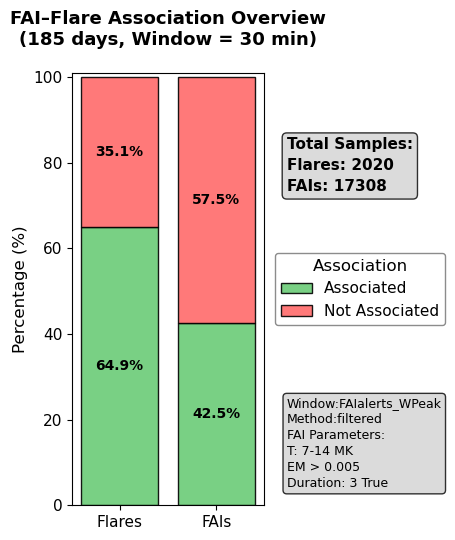

✅ Gráfico guardado en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/filtered185d_FAI_Flare_DualBar_W30minFAIalerts_WPeak_durTrue_3_T7-14_EM0.005.png

--- Resumen ---
Total Flares: 2020 → 64.9% con FAI, 35.1% sin FAI
Total FAIs: 17308 → 42.5% asociados, 57.5% no asociados


In [13]:
plot_fai_flare_dualbar(
    df_fai_assoc=df_fai_assoc,
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    column_assoc="Associated_Flare", 
    fai_column=fai_column)




In [14]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    2020 non-null   object        
 1   StartTime                   2020 non-null   datetime64[ns]
 2   PeakTime                    2020 non-null   datetime64[ns]
 3   EndTime                     2020 non-null   datetime64[ns]
 4   Class                       2020 non-null   object        
 5   ClassLetter                 2020 non-null   object        
 6   ClassNumber                 2020 non-null   float64       
 7   ClassGroup                  2020 non-null   object        
 8   Observatory                 2020 non-null   object        
 9   StartPeak                   2020 non-null   float64       
 10  PeakEnd                     2020 non-null   float64       
 11  StartEnd                    2020 non-null   float64     

In [15]:
df_sorted = df_anticipation_time.sort_values(by="FAIalerts_PeakEnd", ascending=False)[:10]
df_sorted

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,...,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start,FAI_bool
0,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,...,0,10,11.0,26.0,6.0,NaN,NaN,1.733333,0.733333,True
1,Flare_20000606_1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,C,2.4,C1-4.9,GOES,19.0,...,0,7,NaN,16.0,1.0,54.0,66.0,0.842105,NaN,True
2,Flare_20000606_2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,C,2.8,C1-4.9,GOES,10.0,...,0,9,17.0,27.0,2.0,NaN,NaN,2.700000,1.700000,True
3,Flare_20000606_3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,C,2.4,C1-4.9,GOES,4.0,...,0,0,NaN,NaN,NaN,17.0,35.0,NaN,NaN,False
4,Flare_20000606_4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,C,1.8,C1-4.9,GOES,4.0,...,0,3,NaN,3.0,1.0,153.0,156.0,0.750000,NaN,True
5,Flare_20000606_5,2000-06-06 11:40:00,2000-06-06 11:45:00,2000-06-06 11:51:00,C2.5,C,2.5,C1-4.9,GOES,5.0,...,0,3,1.0,6.0,3.0,16.0,18.0,1.200000,0.200000,True
6,Flare_20000606_6,2000-06-06 12:00:00,2000-06-06 12:18:00,2000-06-06 12:25:00,C7.5,C,7.5,C5-9.9,GOES,18.0,...,0,0,NaN,NaN,NaN,27.0,33.0,NaN,NaN,False
7,Flare_20000606_7,2000-06-06 13:10:00,2000-06-06 13:19:00,2000-06-06 13:28:00,M2.7,M,2.7,M1-4.9,GOES,9.0,...,0,0,14.0,23.0,21.0,54.0,61.0,2.555556,1.555556,True
8,Flare_20000606_8,2000-06-06 13:30:00,2000-06-06 13:39:00,2000-06-06 13:46:00,X1.1,X,1.1,X1-4.9,GOES,9.0,...,0,0,NaN,NaN,NaN,11.0,20.0,NaN,NaN,False
9,Flare_20000606_9,2000-06-06 13:56:00,2000-06-06 14:01:00,2000-06-06 14:11:00,M7.1,M,7.1,M5-9.9,GOES,5.0,...,0,0,NaN,NaN,NaN,15.0,22.0,NaN,NaN,False


In [16]:
total = pd.to_numeric(df_anticipation_time["FAIalerts_PeakEnd"], errors="coerce").sum()
total


np.int64(0)

## flares por ventanas

In [17]:
def plot_fai_flare_triplebar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                            column_assoc="Associated_Flare", fai_column="FAIalerts_W"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (discriminado por ventanas temporales)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columnas FAIalerts_WStart, FAIalerts_StartPeak, FAIalerts_PeakEnd)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna base en df_anticipation_time para las estadísticas
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares por ventanas temporales ---
    # Flares con FAI antes del Start
    flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
    flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                   (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
    flares_only_during_peak_end = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                 (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                                 (df_anticipation_time["FAIalerts_PeakEnd"] > 0)).sum()
    flares_without_fai = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                        (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                        (df_anticipation_time["FAIalerts_PeakEnd"] == 0)).sum()

    total_flare = len(df_anticipation_time)
    
    # Verificar que la suma sea correcta
    total_check = (flares_before_start + flares_only_during_start_peak + 
                  flares_only_during_peak_end + flares_without_fai)
    
    if total_check != total_flare:
        print(f"⚠️ Advertencia: Suma de categorías ({total_check}) no coincide con total de flares ({total_flare})")
        # Ajustar por redondeo
        flares_without_fai = total_flare - (flares_before_start + flares_only_during_start_peak + flares_only_during_peak_end)

    # Calcular porcentajes
    pct_before_start = flares_before_start / total_flare * 100
    pct_during_start_peak = flares_only_during_start_peak / total_flare * 100
    pct_during_peak_end = flares_only_during_peak_end / total_flare * 100
    pct_without_fai = flares_without_fai / total_flare * 100

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(7, 6))

    bars = ["Flares", "FAIs"]
    
    # Colores para las diferentes categorías de flares
    colors_flares = ['#2E8B57', '#6BCB77', '#A8E6A3', '#FF6B6B']  # Verde oscuro a claro, luego rojo
    
    # Barra de FLARES (4 segmentos)
    flare_segments = [pct_before_start, pct_during_start_peak, pct_during_peak_end, pct_without_fai]
    flare_labels = ['Before Start', 'Start to Peak', 'Peak to End', 'No FAI']
    
    bottom = 0
    for i, (pct, color, label) in enumerate(zip(flare_segments, colors_flares, flare_labels)):
        ax.bar(bars[0], pct, bottom=bottom, color=color, label=label, alpha=0.9, edgecolor='black')
        # Etiqueta dentro de la barra si el segmento es suficientemente grande
        if pct > 3:
            ax.text(0, bottom + pct/2, f"{pct:.1f}%", 
                    ha='center', va='center', fontsize=9, color='black', fontweight='bold')
        bottom += pct

    # Barra de FAIs (2 segmentos - misma lógica original)
    ax.bar(bars[1], pct_fai_assoc, color='#6BCB77', alpha=0.9, edgecolor='black')
    ax.bar(bars[1], pct_fai_notassoc, bottom=pct_fai_assoc, color='#FF6B6B', alpha=0.9, edgecolor='black')
    
    # Etiquetas para barra de FAIs
    if pct_fai_assoc > 5:
        ax.text(1, pct_fai_assoc / 2, f"{pct_fai_assoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
    if pct_fai_notassoc > 5:
        ax.text(1, pct_fai_assoc + pct_fai_notassoc / 2, f"{pct_fai_notassoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Temporal Distribution\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda para flares (más detallada)
    legend_flares = ax.legend(title="Flare Categories", loc='center left', bbox_to_anchor=(1.02, 0.6),
                             frameon=True, fontsize=10, title_fontsize=11,
                             framealpha=0.9, edgecolor='gray')

    # Leyenda simple para FAIs
    from matplotlib.patches import Patch
    fai_legend_elements = [
        Patch(facecolor='#6BCB77', label='FAI Associated'),
        Patch(facecolor='#FF6B6B', label='FAI Not Associated')
    ]
    legend_fais = ax.legend(handles=fai_legend_elements, title="FAI Status", 
                           loc='center left', bbox_to_anchor=(1.02, 0.4),
                           frameon=True, fontsize=10, title_fontsize=11,
                           framealpha=0.9, edgecolor='gray')
    
    # Añadir ambas leyendas al gráfico
    ax.add_artist(legend_flares)

    # Recuadro con los totales
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.9, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI
    params_text = f"Window: {fai_column}\nMethod: {method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)

    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio a las leyendas
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_TripleBar_W{window_minutes}min{fai_column}_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen Detallado ---")
    print(f"FLARES (Total: {total_flare}):")
    print(f"  • Con FAI ANTES del Start:    {flares_before_start} ({pct_before_start:.1f}%)")
    print(f"  • Con FAI solo ENTRE Start-Peak: {flares_only_during_start_peak} ({pct_during_start_peak:.1f}%)")
    print(f"  • Con FAI solo ENTRE Peak-End:   {flares_only_during_peak_end} ({pct_during_peak_end:.1f}%)")
    print(f"  • SIN FAI en ninguna ventana: {flares_without_fai} ({pct_without_fai:.1f}%)")
    print(f"FAIs (Total: {total_fai}):")
    print(f"  • Asociados a flares:    {fai_assoc_true} ({pct_fai_assoc:.1f}%)")
    print(f"  • No asociados a flares: {fai_assoc_false} ({pct_fai_notassoc:.1f}%)")

# Ejemplo de uso:
# plot_fai_flare_triplebar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
#                         column_assoc="Associated_Flare", fai_column="FAIalerts_W")



In [18]:
# plot_fai_flare_triplebar(df_fai_assoc, 
#                          df_anticipation_time, 
#                          n_days=n, 
#                          window_minutes=window_minutes,
#                          column_assoc="Associated_Flare", 
#                          fai_column=fai_column)


In [19]:
def plot_fai_flare_triplebar2(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                            column_assoc="Associated_Flare", fai_column="FAIalerts_W"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (discriminado por ventanas temporales según fai_column)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columnas FAIalerts_WStart, FAIalerts_StartPeak, FAIalerts_PeakEnd)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica qué ventana usar para determinar flares con FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares usando fai_column ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Determinar qué ventanas mostrar según fai_column ---
    if fai_column == "FAIalerts_W":
        # Ventana completa: mostrar todas las categorías
        flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                       (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
        flares_only_during_peak_end = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                     (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                                     (df_anticipation_time["FAIalerts_PeakEnd"] > 0)).sum()
        flares_without_fai = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                            (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                            (df_anticipation_time["FAIalerts_PeakEnd"] == 0)).sum()
        
        flare_segments = [flares_before_start, flares_only_during_start_peak, flares_only_during_peak_end, flares_without_fai]
        flare_labels = ['Before Start', 'Start to Peak', 'Peak to End', 'No FAI']
        colors_flares = ['#2E8B57', '#6BCB77', '#A8E6A3', '#FF6B6B']
        
    elif fai_column == "FAIalerts_WStart":
        # Solo FAIs antes del Start
        flares_with_fai_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_without_fai_before_start = total_flare - flares_with_fai_before_start
        
        flare_segments = [flares_with_fai_before_start, flares_without_fai_before_start]
        flare_labels = ['FAI Before Start', 'No FAI Before Start']
        colors_flares = ['#2E8B57', '#FF6B6B']
        
    elif fai_column == "FAIalerts_WPeak":
        # FAIs antes del Peak (incluye Before Start + Start to Peak)
        flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                       (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
        flares_without_fai_before_peak = total_flare - (flares_before_start + flares_only_during_start_peak)
        
        flare_segments = [flares_before_start, flares_only_during_start_peak, flares_without_fai_before_peak]
        flare_labels = ['Before Start', 'Start to Peak', 'No FAI Before Peak']
        colors_flares = ['#2E8B57', '#6BCB77', '#FF6B6B']
        
    elif fai_column == "FAIalerts_StartPeak":
        # Solo FAIs entre Start y Peak
        flares_with_fai_start_peak = (df_anticipation_time["FAIalerts_StartPeak"] > 0).sum()
        flares_without_fai_start_peak = total_flare - flares_with_fai_start_peak
        
        flare_segments = [flares_with_fai_start_peak, flares_without_fai_start_peak]
        flare_labels = ['FAI Start-Peak', 'No FAI Start-Peak']
        colors_flares = ['#A8E6A3', '#FF6B6B']
        
    elif fai_column == "FAIalerts_PeakEnd":
        # Solo FAIs entre Peak y End
        flares_with_fai_peak_end = (df_anticipation_time["FAIalerts_PeakEnd"] > 0).sum()
        flares_without_fai_peak_end = total_flare - flares_with_fai_peak_end
        
        flare_segments = [flares_with_fai_peak_end, flares_without_fai_peak_end]
        flare_labels = ['FAI Peak-End', 'No FAI Peak-End']
        colors_flares = ['#A8E6A3', '#FF6B6B']
        
    else:
        # Por defecto, usar ventana completa
        flares_with_fai = (df_anticipation_time[fai_column] > 0).sum()
        flares_without_fai = total_flare - flares_with_fai
        
        flare_segments = [flares_with_fai, flares_without_fai]
        flare_labels = [f'With {fai_column}', f'Without {fai_column}']
        colors_flares = ['#6BCB77', '#FF6B6B']

    # Calcular porcentajes
    pct_flare_segments = [segment / total_flare * 100 for segment in flare_segments]

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(7, 6))

    bars = ["Flares", "FAIs"]
    
    # Barra de FLARES (segmentos variables según fai_column)
    bottom = 0
    for i, (pct, color, label) in enumerate(zip(pct_flare_segments, colors_flares, flare_labels)):
        ax.bar(bars[0], pct, bottom=bottom, color=color, label=label, alpha=0.9, edgecolor='black')
        # Etiqueta dentro de la barra si el segmento es suficientemente grande
        if pct > 3:
            ax.text(0, bottom + pct/2, f"{pct:.1f}%", 
                    ha='center', va='center', fontsize=9, color='black', fontweight='bold')
        bottom += pct

    # Barra de FAIs (2 segmentos - misma lógica original)
    ax.bar(bars[1], pct_fai_assoc, color='#6BCB77', alpha=0.9, edgecolor='black')
    ax.bar(bars[1], pct_fai_notassoc, bottom=pct_fai_assoc, color='#FF6B6B', alpha=0.9, edgecolor='black')
    
    # Etiquetas para barra de FAIs
    if pct_fai_assoc > 5:
        ax.text(1, pct_fai_assoc / 2, f"{pct_fai_assoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
    if pct_fai_notassoc > 5:
        ax.text(1, pct_fai_assoc + pct_fai_notassoc / 2, f"{pct_fai_notassoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association: {fai_column}\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda para flares
    legend_flares = ax.legend(title=f"Flare Categories\n({fai_column})", 
                             loc='center left', bbox_to_anchor=(1.02, 0.6),
                             frameon=True, fontsize=10, title_fontsize=11,
                             framealpha=0.9, edgecolor='gray')

    # Leyenda simple para FAIs
    from matplotlib.patches import Patch
    fai_legend_elements = [
        Patch(facecolor='#6BCB77', label='FAI Associated'),
        Patch(facecolor='#FF6B6B', label='FAI Not Associated')
    ]
    legend_fais = ax.legend(handles=fai_legend_elements, title="FAI Status", 
                           loc='center left', bbox_to_anchor=(1.02, 0.35),
                           frameon=True, fontsize=10, title_fontsize=11,
                           framealpha=0.9, edgecolor='gray')
    
    # Añadir ambas leyendas al gráfico
    ax.add_artist(legend_flares)

    # Recuadro con los totales
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.9, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI
    params_text = f"Window: {fai_column}\nMethod: {method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)

    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio a las leyendas
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_TripleBar_{fai_column}_W{window_minutes}min_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print(f"\n--- Resumen para {fai_column} ---")
    print(f"FLARES (Total: {total_flare}):")
    for label, count, pct in zip(flare_labels, flare_segments, pct_flare_segments):
        print(f"  • {label}: {count} ({pct:.1f}%)")
    print(f"FAIs (Total: {total_fai}):")
    print(f"  • Asociados a flares:    {fai_assoc_true} ({pct_fai_assoc:.1f}%)")
    print(f"  • No asociados a flares: {fai_assoc_false} ({pct_fai_notassoc:.1f}%)")

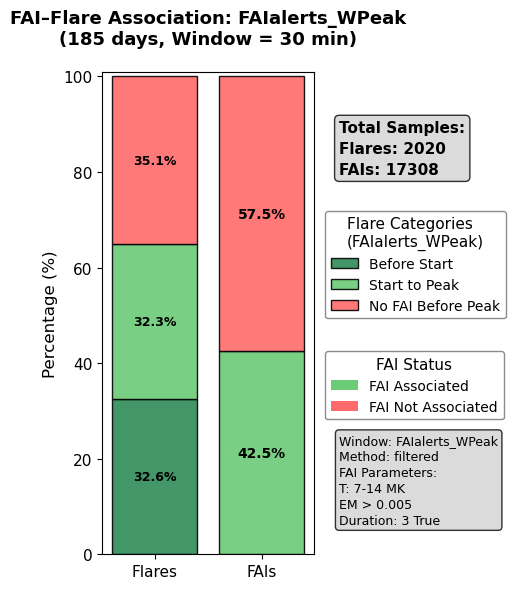

✅ Gráfico guardado en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/filtered185d_FAI_Flare_TripleBar_FAIalerts_WPeak_W30min_durTrue_3_T7-14_EM0.005.png

--- Resumen para FAIalerts_WPeak ---
FLARES (Total: 2020):
  • Before Start: 658 (32.6%)
  • Start to Peak: 652 (32.3%)
  • No FAI Before Peak: 710 (35.1%)
FAIs (Total: 17308):
  • Asociados a flares:    7355 (42.5%)
  • No asociados a flares: 9953 (57.5%)


In [20]:
plot_fai_flare_triplebar2(df_fai_assoc, 
                         df_anticipation_time, 
                         n_days=n, 
                         window_minutes=window_minutes,
                         column_assoc="Associated_Flare", 
                         fai_column=fai_column)


# pruebas

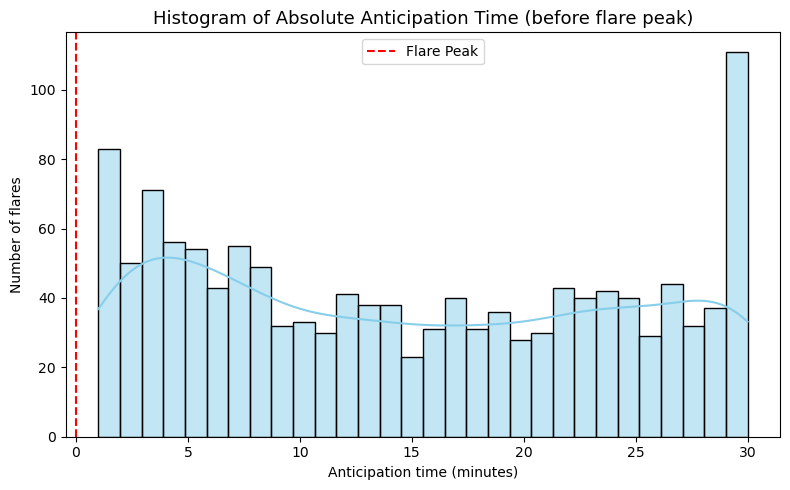

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df_anticipation_time["AnticipationPeak"].dropna(), bins=30, kde=True, color="skyblue")
plt.axvline(0, color="red", linestyle="--", label="Flare Peak")
plt.title("Histogram of Absolute Anticipation Time (before flare peak)", fontsize=13)
plt.xlabel("Anticipation time (minutes)")
plt.ylabel("Number of flares")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "hist_absolute_anticipation.png"), dpi=300)
plt.show()

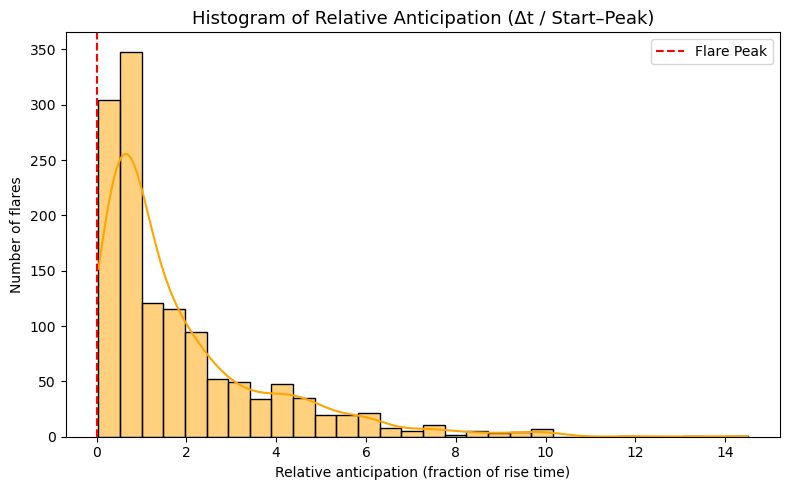

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(df_anticipation_time["RelAnticipation_Peak"].dropna(), bins=30, kde=True, color="orange")
plt.axvline(0, color="red", linestyle="--", label="Flare Peak")
plt.title("Histogram of Relative Anticipation (Δt / Start–Peak)", fontsize=13)
plt.xlabel("Relative anticipation (fraction of rise time)")
plt.ylabel("Number of flares")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "hist_relative_anticipation.png"), dpi=300)
plt.show()


/tmp/ipykernel_5703/2294547633.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Flare class")


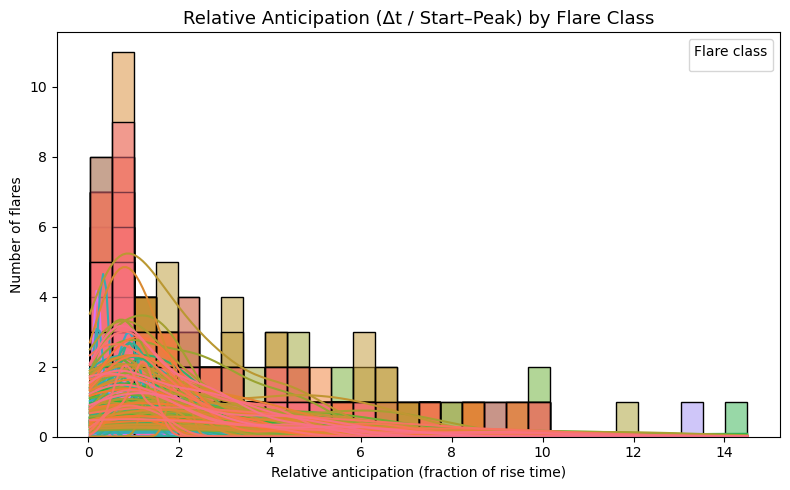

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_anticipation_time, x="RelAnticipation_Peak", hue="Class", bins=30, kde=True)
plt.title("Relative Anticipation (Δt / Start–Peak) by Flare Class", fontsize=13)
plt.xlabel("Relative anticipation (fraction of rise time)")
plt.ylabel("Number of flares")
plt.legend(title="Flare class")
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "hist_relative_anticipation_by_class.png"), dpi=300)
plt.show()